# A hybrid method for heart disease diagnosis utilizing feature selection based ensemble classifier model generation

The aim of this study is to replicate the research conducted by Abdollahi and Moghaddam (2022) to gain a deeper understanding of various feature selection methods, specifically ReliefF, FCBF, and genetic algorithms. This research focuses on improving the accuracy of heart disease diagnosis by using an ensemble classification model that incorporates a genetic algorithm and feature selection. The proposed model achieved a high accuracy of 97.57%, demonstrating its potential for effective implementation in healthcare settings.

* Research Paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9081959/
* Dataset: https://archive.ics.uci.edu/dataset/145/statlog+heart

## Importing the libraries

Let's import the necessary libraries to get started.

In [45]:
import time
import warnings
from IPython.display import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from fcbf import fcbf
from skrebate import ReliefF

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

warnings.filterwarnings("ignore")

## Loading the "Statlog (Heart)" data

Now, let's read the statlog heart disease dataset into a dataframe.

In [46]:
heart_df = pd.read_csv('data/heart.dat', header=None, sep=" ")
heart_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1


We now add the respective column names to the dataframe.

In [47]:
column_names = [
    "age", "sex", "cp_type", "rest_bp", "cholesterol", "fast_bs", "rest_ecg",
    "max_hr", "ex_angina", "old_peak", "slope", "num_vessels", "thal", "hd_presence"
]

heart_df.columns = column_names
heart_df.head()

,age,sex,cp_type,rest_bp,cholesterol,fast_bs,rest_ecg,max_hr,ex_angina,old_peak,slope,num_vessels,thal,hd_presence
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1


## Feature Explanation

*__Variables Table__*

|     Variable Name    |   Role  |     Type    | Description                                                    |
|:--------------------:|:-------:|:-----------:|----------------------------------------------------------------|
| age                  | Feature | Continuous  | demographic - age                                              |
| sex                  | Feature | Binary      | demographic - sex                                              |
| chest-pain           | Feature | Categorical | chest pain type                                                |
| rest-bp              | Feature | Continuous  | resting blood pressure                                         |
| serum-chol           | Feature | Continuous  | serum cholesterol                                              |
| fasting-blood-sugar  | Feature | Binary      | fasting blood sugar &gt; 120 mg/dl                           |
| electrocardiographic | Feature | Categorical | resting electrocardiographic results                         |
| max-heart-rate       | Feature | Continuous  | maximum heart rate achieved                                    |
| angina               | Feature | Binary      | exercise induced anigna                                        |
| oldpeak              | Feature | Continuous  | oldpeak = ST depression induced by exercise relative to rest |
| slope                | Feature | Integer     | the slope of the peak exercise ST segment                     |
| major-vessels        | Feature | Continuous  | number of major vessels (0-3) colored by fluorosopy            |
| thal                 | Feature | Categorical | thal: 3 = normal; 6 = fixed; 7 = reversable defect             |
| heart-disease        | Target  | Binary      | absence = 1 or presence = 2 of heart disease                   |

## Exploratory Data Analysis

We now carry out the preliminary EDA on the dataset to check for errors or inconsistency in the data, missing values, unusual patterns and overall just getting to know the data better.

In [48]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          270 non-null    float64
 1   sex          270 non-null    float64
 2   cp_type      270 non-null    float64
 3   rest_bp      270 non-null    float64
 4   cholesterol  270 non-null    float64
 5   fast_bs      270 non-null    float64
 6   rest_ecg     270 non-null    float64
 7   max_hr       270 non-null    float64
 8   ex_angina    270 non-null    float64
 9   old_peak     270 non-null    float64
 10  slope        270 non-null    float64
 11  num_vessels  270 non-null    float64
 12  thal         270 non-null    float64
 13  hd_presence  270 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 29.7 KB


We can see below that we have 14 features and 270 observations. The target variable 'hd_presence' is binary and our features are mixed data types. The numerical variables are in different scales of measurement, so it will be necessary to standardize our data before carrying out any modelling with our data. 

Now, lets take a look a more indepth look into the numerical data. 

### Numerical Data

In [49]:
numerical_features = ['age', 'rest_bp', 'cholesterol', 'max_hr', 'old_peak', 'num_vessels']

numerical_df = heart_df[numerical_features]
numerical_df.describe()

,age,rest_bp,cholesterol,max_hr,old_peak,num_vessels
count,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000
mean,54.433333,131.344444,249.659259,149.677778,1.05000,0.670370
std,9.109067,17.861608,51.686237,23.165717,1.14521,0.943896
min,29.000000,94.000000,126.000000,71.000000,0.00000,0.000000
25%,48.000000,120.000000,213.000000,133.000000,0.00000,0.000000
50%,55.000000,130.000000,245.000000,153.500000,0.80000,0.000000
75%,61.000000,140.000000,280.000000,166.000000,1.60000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.20000,3.000000


From the above data we can see the presence of outliers in most of the numerical features of the data. So, we will take a look at it visually using a boxplot to get a better idea of the outliers present.

We can also see that num_vessels does not seem to be a numerical feature, so we will be removing it form the list.

In [50]:
numerical_features = ['age', 'rest_bp', 'cholesterol', 'max_hr', 'old_peak']

numerical_df = heart_df[numerical_features]
numerical_df.describe()

,age,rest_bp,cholesterol,max_hr,old_peak
count,270.000000,270.000000,270.000000,270.000000,270.00000
mean,54.433333,131.344444,249.659259,149.677778,1.05000
std,9.109067,17.861608,51.686237,23.165717,1.14521
min,29.000000,94.000000,126.000000,71.000000,0.00000
25%,48.000000,120.000000,213.000000,133.000000,0.00000
50%,55.000000,130.000000,245.000000,153.500000,0.80000
75%,61.000000,140.000000,280.000000,166.000000,1.60000
max,77.000000,200.000000,564.000000,202.000000,6.20000


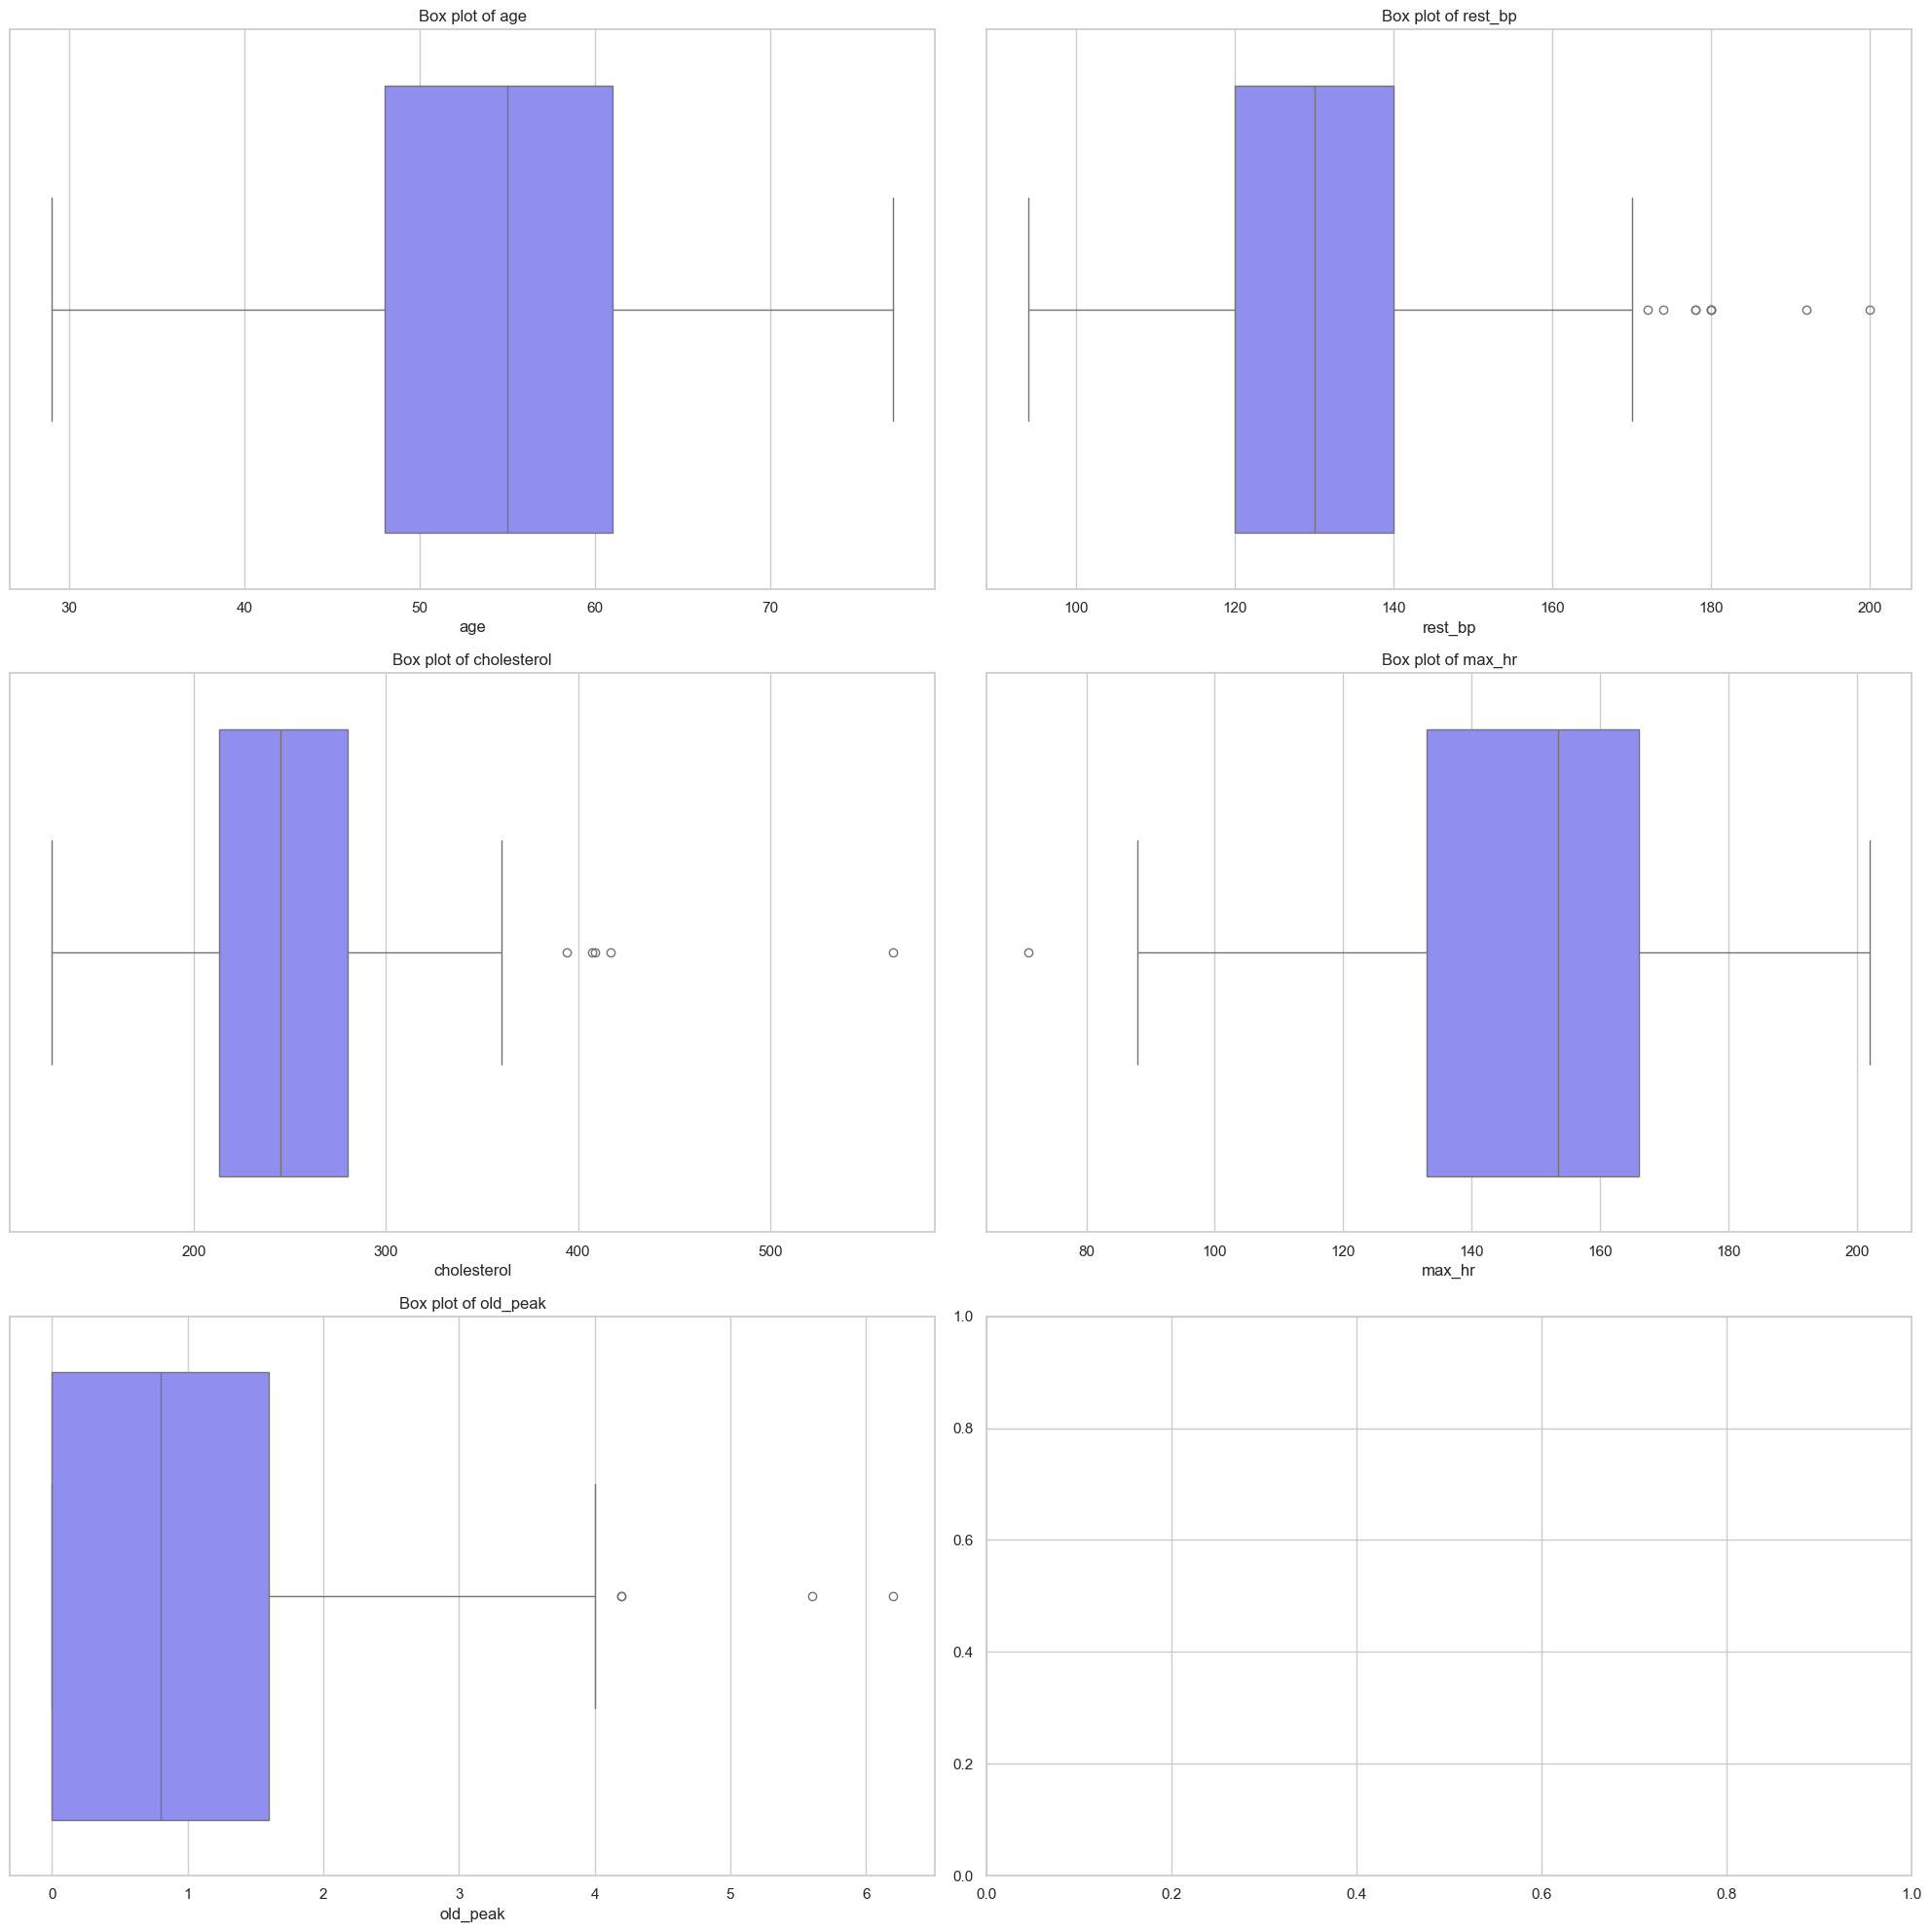

In [51]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sns.boxplot(x=heart_df[col], ax=axes[i], palette='cool')
    axes[i].set_title(f'Box plot of {col}')

plt.tight_layout()
plt.show()

Consistent with our previous observations there is the presence of outliers in all the features of the data except age. However, these outliers appear to be natural variations in the distribution. Since these are not due to measurement errors, we will retain them. Removing a genuine outlier, which reflects the actual condition of a patient, could compromise the integrity of our models.

After this we take a look at the scatter plot matrix to see if there is the presence of correlation between the numerical features of the dataset.

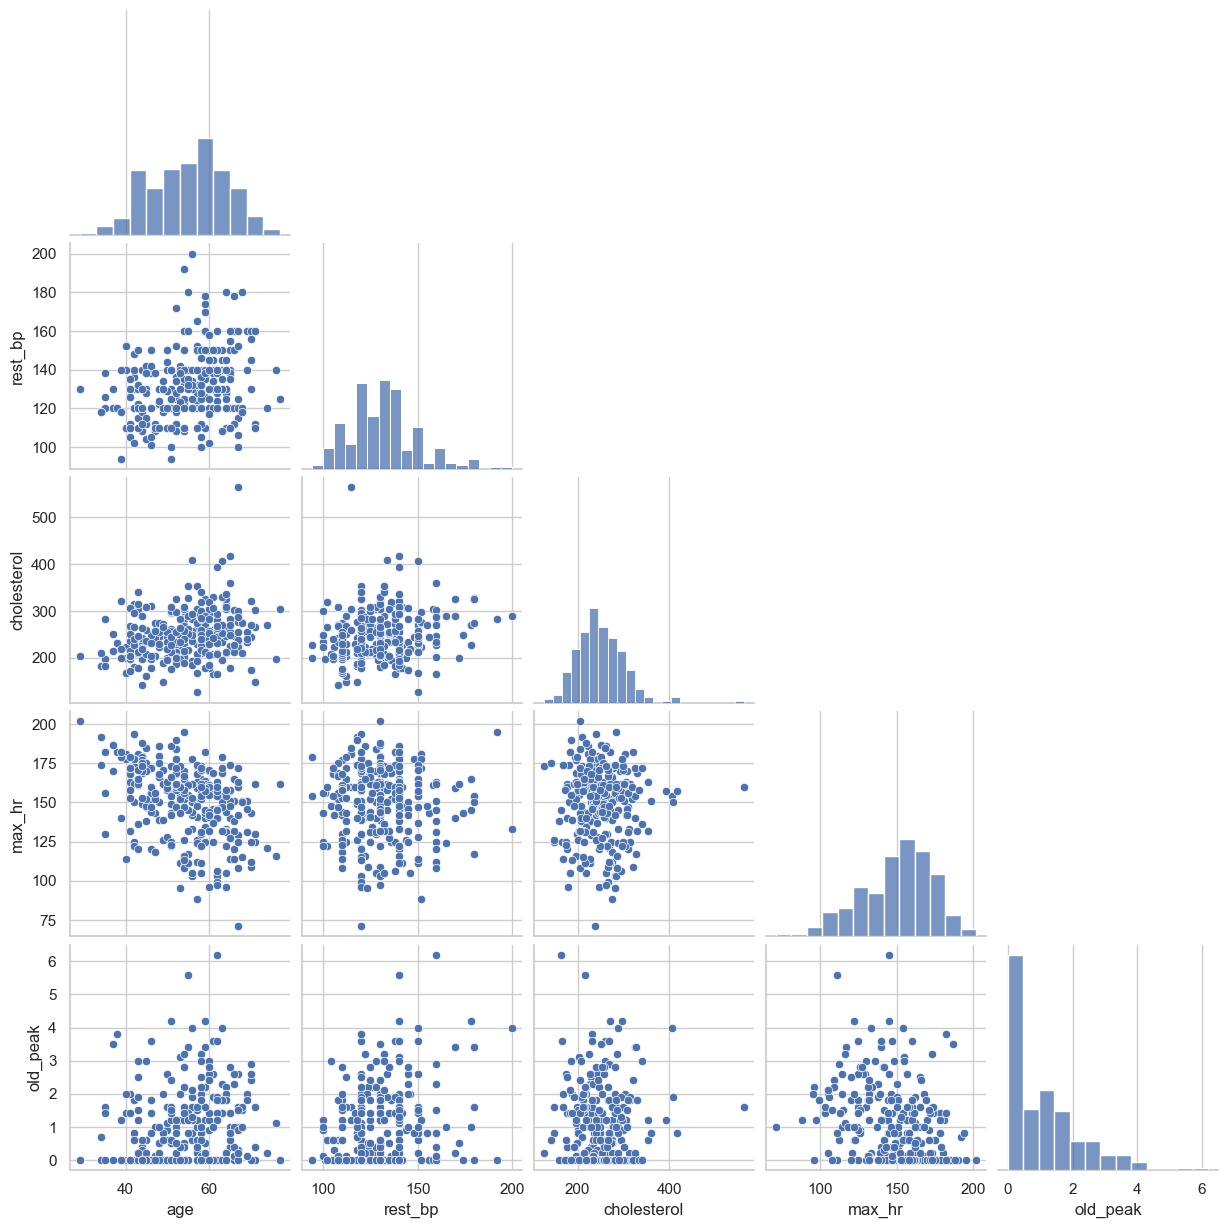

In [52]:
sns.pairplot(numerical_df, diag_kind='hist', corner=True)
plt.show()

Let's take a more numerical approach to see the exact values of the correlation.

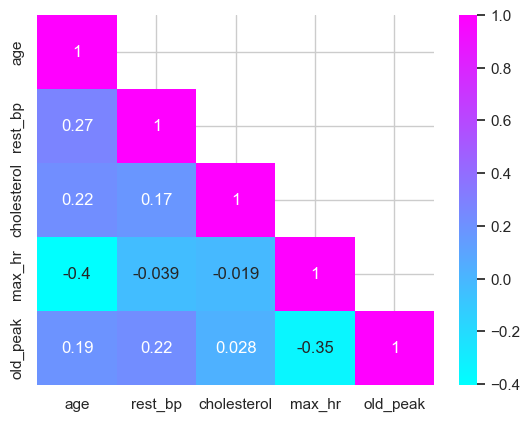

In [53]:
corr = numerical_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
np.fill_diagonal(mask, False)

sns.heatmap(corr, annot=True, cmap='cool', mask=mask)
plt.show()

As we can see there doesn't seem to be any significant linear correlation between the features. There is a moderate negative correlation between age and maximum heart rate, suggesting that older individuals tend to have lower maximum heart rates. Maximum heart rate and old peak have a moderate negative correlation. Other variable pairs show weak correlations with each other.

In [54]:
df_with_const = add_constant(heart_df[numerical_features])

vif = pd.DataFrame()
vif["feature"] = df_with_const.columns
vif["VIF"] = [variance_inflation_factor(df_with_const.values, i) for i in range(df_with_const.shape[1])]

vif

,feature,VIF
0,const,166.282898
1,age,1.346324
2,rest_bp,1.155639
3,cholesterol,1.071767
4,max_hr,1.344857
5,old_peak,1.198864


### Categorical Data

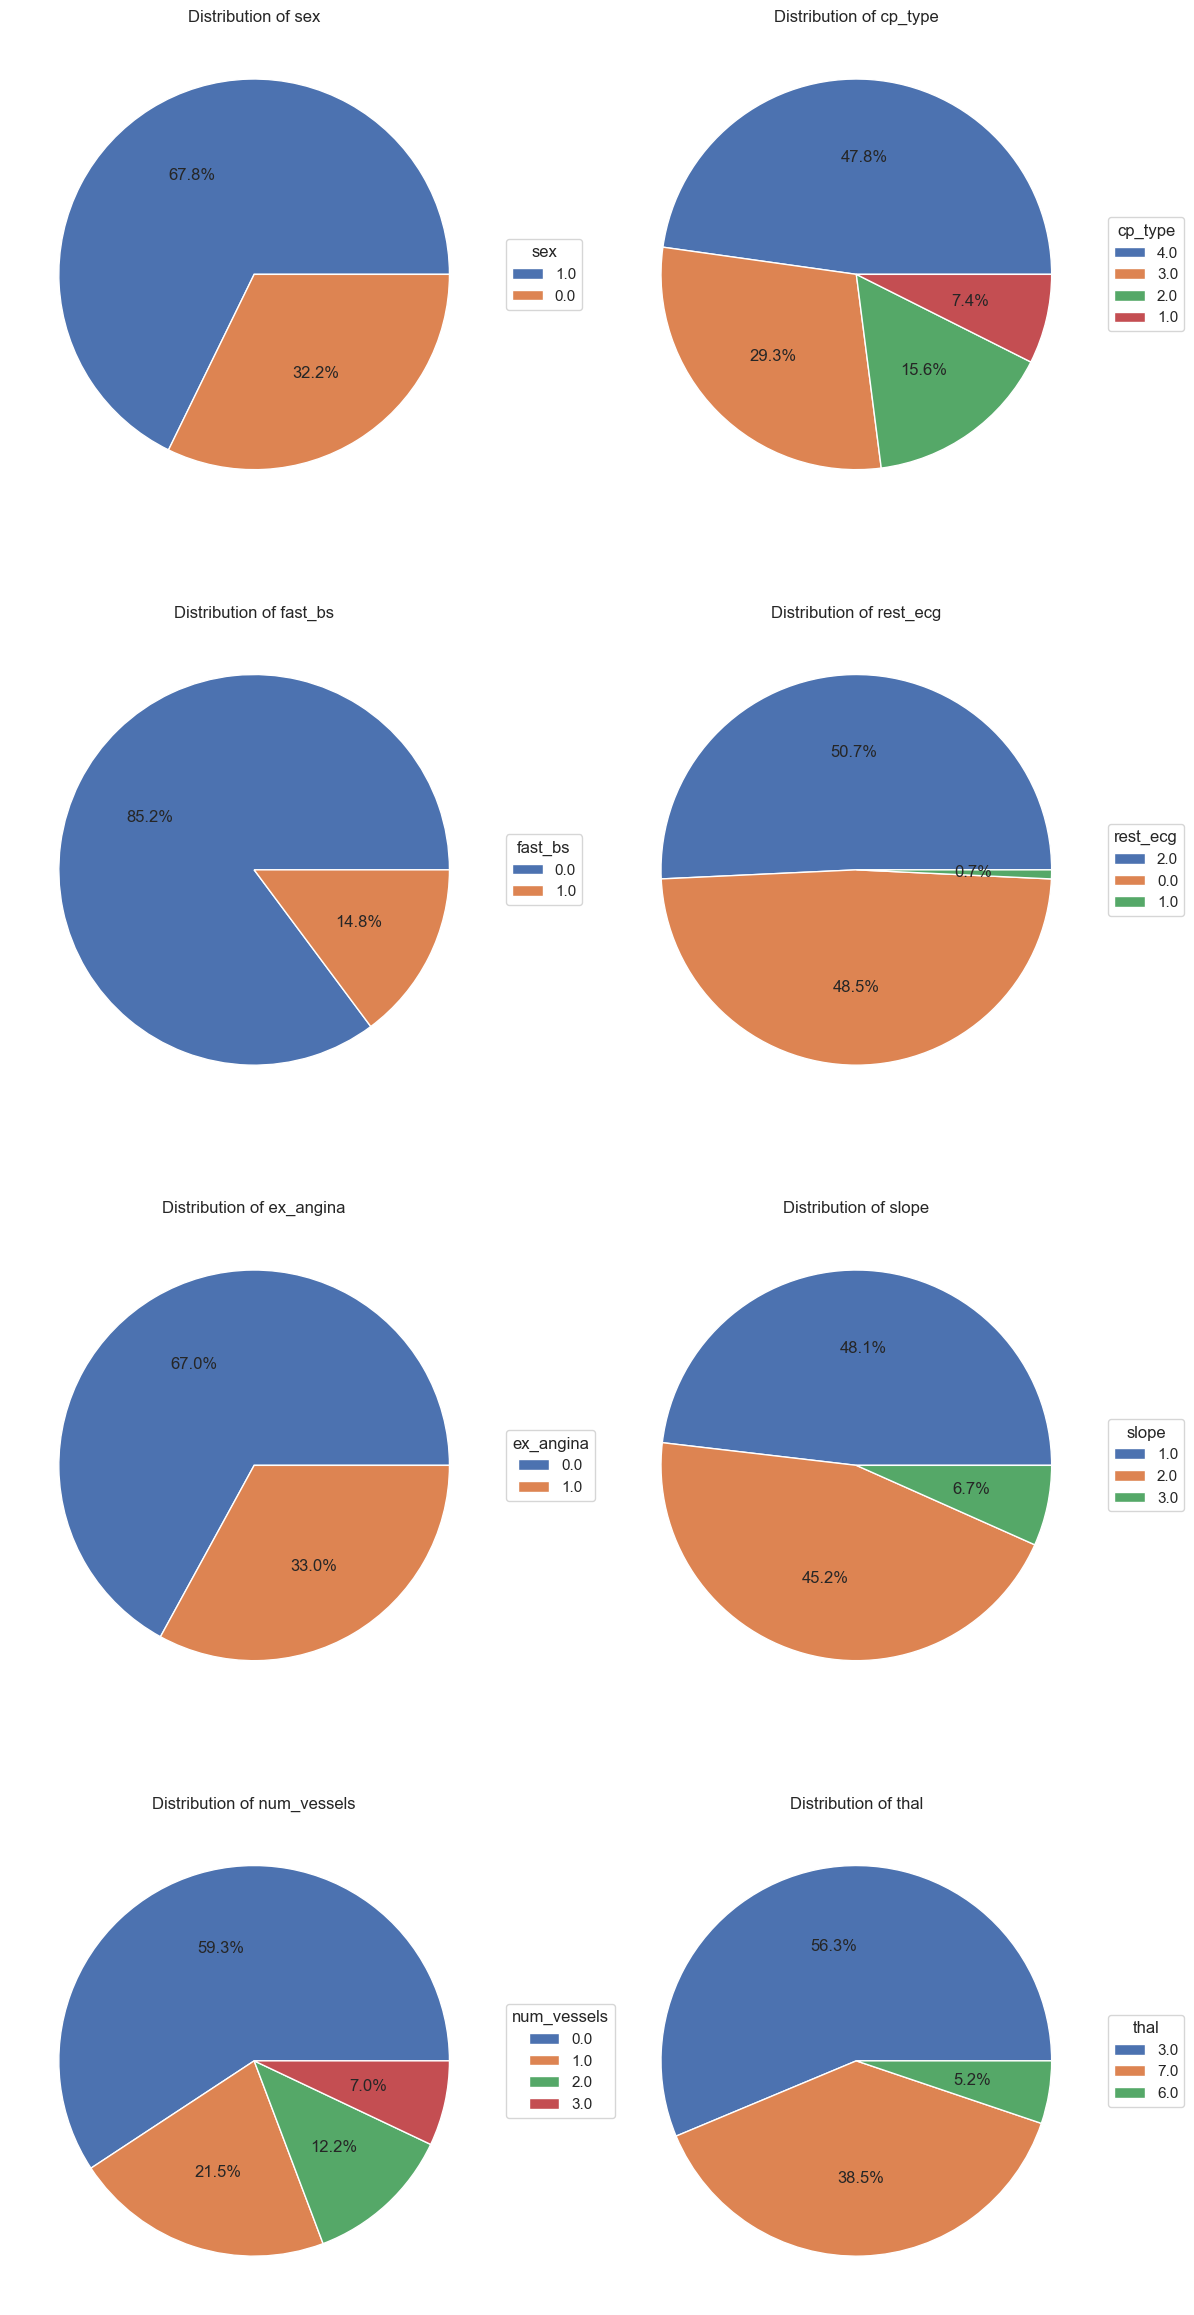

In [55]:
categorical_features = [
    'sex', 'cp_type', 'fast_bs', 'rest_ecg', 'ex_angina', 'slope', 'num_vessels', 'thal'
]

i = 0
n_cols = 2
n_rows = (len(categorical_features) + n_cols - 1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 6))

if n_rows > 1:
    axs = axs.flatten()

for i, column in enumerate(categorical_features):
    counts = heart_df[column].value_counts()
    ax = axs[i]
    wedges, texts, autotexts = ax.pie(counts, autopct='%1.1f%%')
    ax.set_title(f'Distribution of {column}')
    ax.legend(wedges, counts.index, title=column, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

The dataset displays notable imbalances across several categorical features. As we can see from the pie charts above:
- Males (1) make up most of the data with about 68%.
- Type 4 chest pain appears to be the most common type of chest pain making up about 48%.
- About 85% of the fasting blood sugar is less than 120 mg/dl.
- Rest electrocardiograph results are evenly split between values 0 and 2.
- 67% don't have exercise induced angina.
- The slope is also evenly split between values 1 and 2.
- 0 number of major vessels make up 59%.
- Normal (3) thal make up the most with 56%.

### Target Data

Now, we take a look at our target variable i.e. the presence or absence of heart disease. 

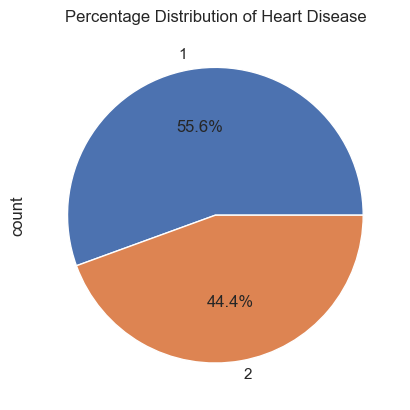

In [56]:
heart_df['hd_presence'].value_counts().plot(kind="pie", autopct='%1.1f%%')
plt.title('Percentage Distribution of Heart Disease')
plt.show()

However, the distribution of our target variable is almost equal between the two classes, indicating an even split in the presence of heart disease.

Text(0.5, 1.0, 'Gender and Presence of Heart Disease')

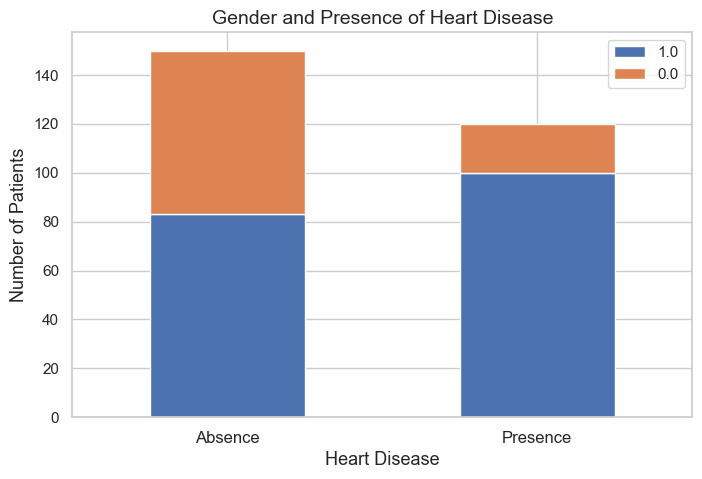

In [88]:
def bar_chart(feature):
    absence = heart_df[heart_df['hd_presence'] == 1][feature].value_counts()
    presence = heart_df[heart_df['hd_presence'] == 2][feature].value_counts()
    df_bar = pd.DataFrame([absence, presence])
    df_bar.index = ['Absence', 'Presence']
    df_bar.plot(kind='bar', stacked=True, figsize=(8, 5))


bar_chart('sex')
plt.xlabel('Heart Disease', fontsize=13)
plt.xticks(rotation=0, fontsize=12)
plt.ylabel('Number of Patients', fontsize=13)
plt.legend()
plt.title('Gender and Presence of Heart Disease', fontsize=14)
plt.show()

Among the individuals identified as Males(1), there are 83 cases of absence and 100 cases of presence. This shows that the presence of the condition is more common in Males(1) compared to Females(0).

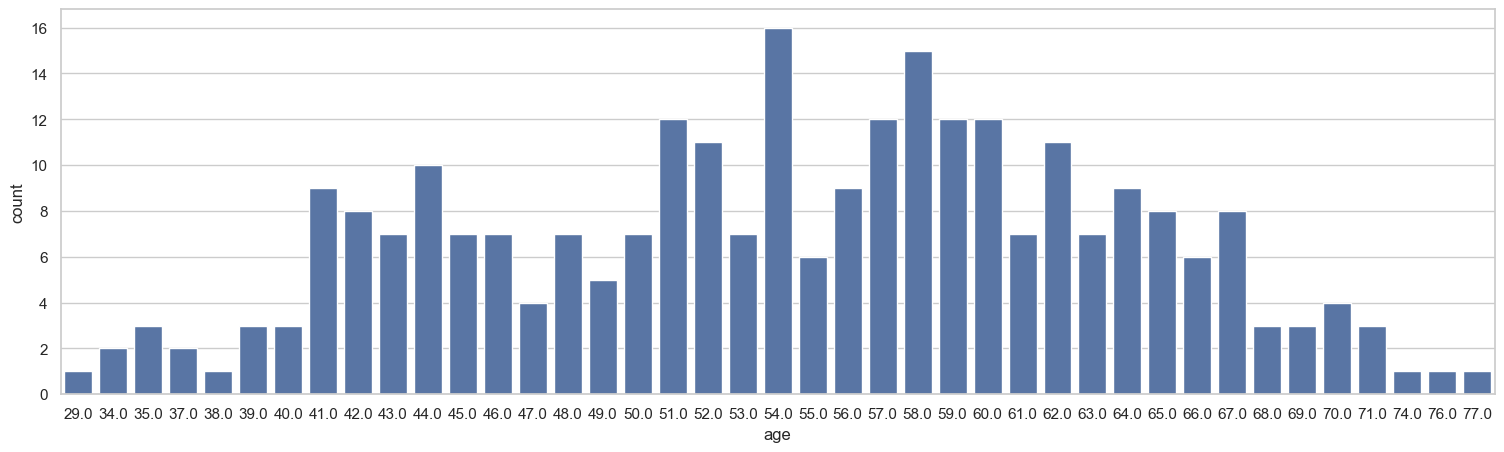

In [58]:
ax = sns.countplot(x='age', data=heart_df)
ax.figure.set_size_inches(18.5, 5)

The plot is a histogram that shows the distribution of a variable "age" with the x-axis representing age values and the y-axis representing the count of occurrences for each age value. 
 - The ages range from 29 to 77. 
 - The age with the highest count is 54, with 16 occurrences. 
 - There are noticeable peaks around ages 54, 58, 51, and 44, suggesting these are more common ages in the dataset. 
 - There are fewer counts for ages at the extreme ends of the range, such as 29, 74, 76, and 77, indicating these ages are less common in the dataset.

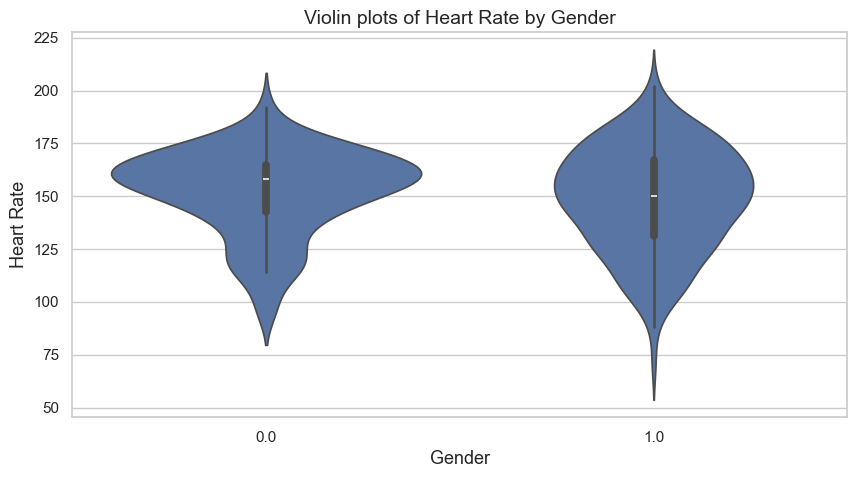

In [59]:
plt.figure(figsize=(10, 5))
sns.violinplot(x='sex', y='max_hr', data=heart_df)
plt.title('Violin plots of Heart Rate by Gender', fontsize=14)
plt.xlabel('Gender', fontsize=13)
plt.ylabel('Heart Rate', fontsize=13)
plt.show()

Both females and males have similar median max heart rate values around 150, with relatively similar distributions. Males have a slightly narrower interquartile range and a more peaked density. Both genders exhibit a wide spread of data, with maximum heart rates ranging from approximately 75 to 200.​

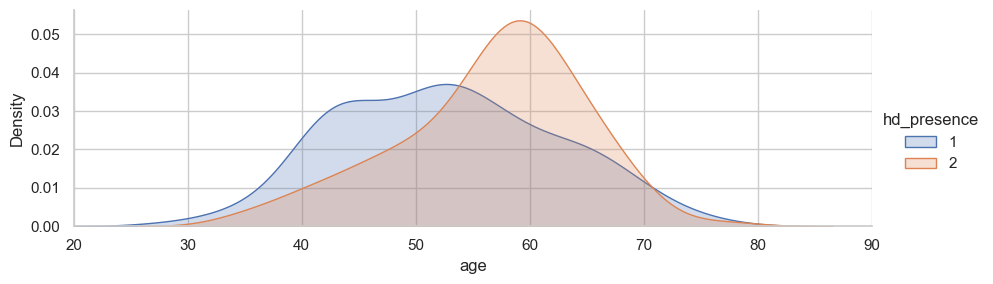

In [91]:
facet = sns.FacetGrid(heart_df, hue="hd_presence", aspect=3)
facet.map(sns.kdeplot, 'age', shade=True)
facet.set(xlim=(0, heart_df['age'].max()))
facet.add_legend()
plt.xlim(20, 90)
plt.show()

TODO: Explain the plot above

### Missing Data

In [62]:
missing_data = heart_df.isnull().sum().reset_index()
missing_data.columns = ['Column', 'Missing Count']
missing_data['Missing Percentage'] = (missing_data['Missing Count'] / len(heart_df)) * 100
missing_data

,Column,Missing Count,Missing Percentage
0,age,0,0.0
1,sex,0,0.0
2,cp_type,0,0.0
3,rest_bp,0,0.0
4,cholesterol,0,0.0
5,fast_bs,0,0.0
6,rest_ecg,0,0.0
7,max_hr,0,0.0
8,ex_angina,0,0.0
9,old_peak,0,0.0


From the table above we see below that there are no missing data in our dataset.

## Our Workflow

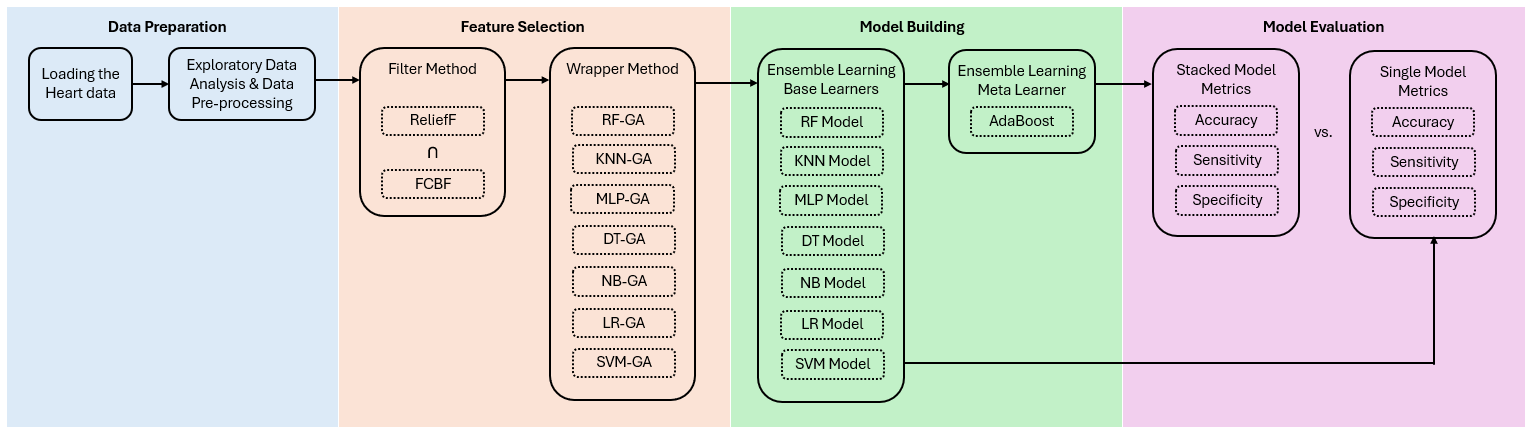

In [63]:
Image(filename="./image/workflow.png")

TODO: Explain the workflow

## Feature Selection

### ReliefF Feature Ranking

ReliefF is a filtering feature selection algorithm that was developed as an extension of the Relief algorithm to handle multi-class problems effectively. It operates by selecting features based on their ability to distinguish between different classes, utilizing nearest neighbor samples to weigh feature importance. The method involves calculating the difference between the within-class and between-class distances for various features, updating a feature weighting vector accordingly (Wang et al., 2016).

In [64]:
y = heart_df['hd_presence']
X = heart_df.drop('hd_presence', axis=1)

In [65]:
reliefF = ReliefF(verbose=True, n_jobs=-1, n_features_to_select=len(X.columns), discrete_threshold=2)

reliefF.fit(X.to_numpy(), y.to_numpy())
feature_importance = reliefF.feature_importances_

feature_rank_df = pd.DataFrame({
    'Feature': X.columns,
    'feature_importance': feature_importance,
})

Created distance array in 0.0020003318786621094 seconds.
Feature scoring under way ...
Completed scoring in 2.342318534851074 seconds.


In [66]:
relief_df = feature_rank_df.sort_values(by='feature_importance', ascending=False)
relief_df.reset_index(drop=True, inplace=True)
relief_df

,Feature,feature_importance
0,thal,0.281435
1,num_vessels,0.177778
2,ex_angina,0.175222
3,cp_type,0.157889
4,slope,0.139037
5,old_peak,0.108556
6,max_hr,0.101460
7,sex,0.073778
8,age,0.036615
9,rest_ecg,0.020259


### Fast Correlation-Based Filter (FCBF) Feature Ranking

Fast Correlation-Based Filter (FCBF) is a feature selection algorithm designed to handle high-dimensional data efficiently by identifying both relevant and redundant features. It employs the symmetrical uncertainty (SU) measure to assess the correlation between features and the class label. The FCBF algorithm operates in two main phases: the first phase selects relevant features based on a predefined SU threshold, and the second phase eliminates redundant features among the selected ones. This two-step process allows FCBF to significantly reduce dimensionality while maintaining or even improving the classification accuracy (Yu & Liu, n.d.).

In [68]:
_, _, correlations = fcbf(X, y, base=2)
correlations_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation'])

Relevant Features: ['thal', 'cp_type', 'num_vessels', 'ex_angina', 'slope', 'rest_ecg']
Irrelevant Features: ['fast_bs', 'age', 'rest_bp', 'sex', 'old_peak', 'max_hr', 'cholesterol']


In [69]:
fcbf_df = correlations_df.sort_values(by='Correlation', ascending=False)
fcbf_df.reset_index(drop=True, inplace=True)

Now we look at the comparisons between the feature selection methods.

In [70]:
display_df = pd.concat([relief_df, fcbf_df], axis=1)
display_df

,Feature,feature_importance,Feature,Correlation
0,thal,0.281435,thal,0.188802
1,num_vessels,0.177778,cholesterol,0.152974
2,ex_angina,0.175222,cp_type,0.141601
3,cp_type,0.157889,num_vessels,0.137197
4,slope,0.139037,ex_angina,0.136349
5,old_peak,0.108556,max_hr,0.099243
6,max_hr,0.101460,slope,0.097627
7,sex,0.073778,old_peak,0.094246
8,age,0.036615,sex,0.070496
9,rest_ecg,0.020259,rest_bp,0.051563


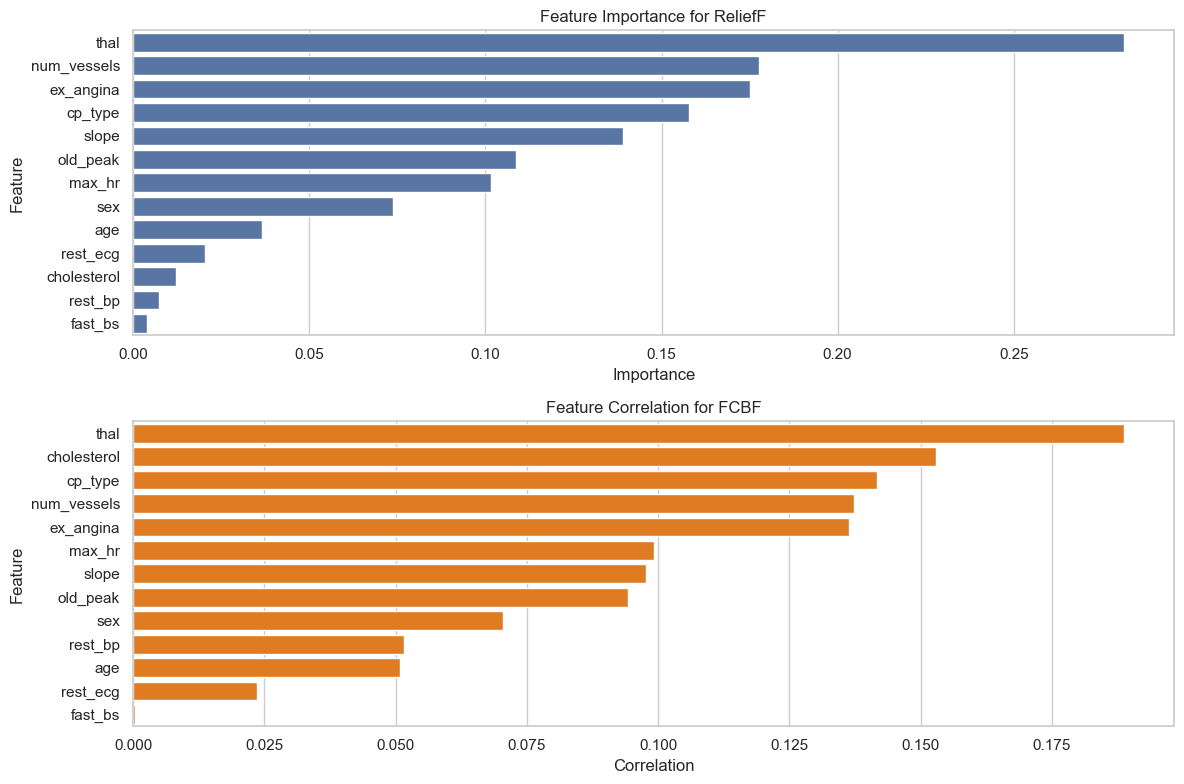

In [92]:

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
sns.barplot(x='feature_importance', y='Feature', data=relief_df, color='b')
plt.title('Feature Importance for ReliefF')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.subplot(2, 1, 2)
sns.barplot(x='Correlation', y='Feature', data=fcbf_df, color='#FF7900')
plt.title('Feature Correlation for FCBF')
plt.xlabel('Correlation')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()

The authors employed ReliefF and FCBF attribute evaluators along with the Ranker search method, though it is unclear whether they utilized a Python package or the Java-based GUI, WEKA. Their research identified age, slope, old_peak, and num_vessels as the lowest ranking features, which differs significantly from our findings.

To replicate the study, we proceeded with the same nine features selected by the authors after ReliefF and FCBF feature selection. Below, we compare the accuracy of the base model with all features to the model with the selected features. The authors reported an accuracy of 0.9416 using ReliefF with nine features.

Thing to take note of from our analysis, for both feature selection methods, among the last four features three of the features rest_ecg, rest_bp, and fast_bs are common.

### Preliminary Model Analysis

Here, we are using a few classifiers to get an idea of how the selected features perform during classification as compared to the whole feature set. 

In [72]:
X_train_org, X_test_org, y_train_org, y_test_org = train_test_split(X, y, test_size=0.2, random_state=42)

X_selected = heart_df.drop(["hd_presence", "age", "slope", "old_peak", "num_vessels"], axis=1)
y_selected = heart_df["hd_presence"]

X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected, y_selected,
                                                                                        test_size=0.2, random_state=42)

In [73]:
classifiers = [
    ('DecisionTree', DecisionTreeClassifier(), {'classifier__max_depth': [5, 10, 15]}),
    ('LogisticRegression', LogisticRegression(max_iter=1000), {'classifier__C': [0.1, 1, 10]})
]


def perform_grid_search(X_train, y_train, title):
    print(title, '\n')

    for tag, model, params in classifiers:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])

        grid = GridSearchCV(estimator=pipeline, param_grid=params, cv=5, scoring='accuracy')

        start_time = time.time()
        grid.fit(X_train, y_train)
        end_time = time.time()

        elapsed_t = end_time - start_time

        print("Classifier: {}".format(tag))
        print("Best score: {:.4f}".format(grid.best_score_))
        print("Elapsed Time: {:.4f} seconds\n".format(elapsed_t))

#### Base Model

In [74]:
perform_grid_search(X_train_org, y_train_org, "Base Model Grid Search")

Base Model Grid Search 

Classifier: DecisionTree
Best score: 0.6993
Elapsed Time: 0.0800 seconds

Classifier: LogisticRegression
Best score: 0.8244
Elapsed Time: 0.0865 seconds



#### Selected Features Model

In [75]:
perform_grid_search(X_train_selected, y_train_selected, "Selected Features Model Grid Search")

Selected Features Model Grid Search 

Classifier: DecisionTree
Best score: 0.6941
Elapsed Time: 0.0801 seconds

Classifier: LogisticRegression
Best score: 0.7733
Elapsed Time: 0.0815 seconds



The models seem to perform marginally worse when we just use the selected features.

## Genetic Algorithm

Genetic algorithm is an optimization technique inspired by the process of natural selection, simulating the evolutionary principles of reproduction, mutation, and selection to find the best solution to a problem. The key components of genetic algorithms include a population of candidate solutions encoded as chromosomes, a fitness function to evaluate these solutions, selection mechanisms to choose the fittest individuals, crossover methods to combine selected individuals to produce offspring, and mutation processes to introduce variations (Carr, 2014). 

### Basic Loop of Genetic Algorithm

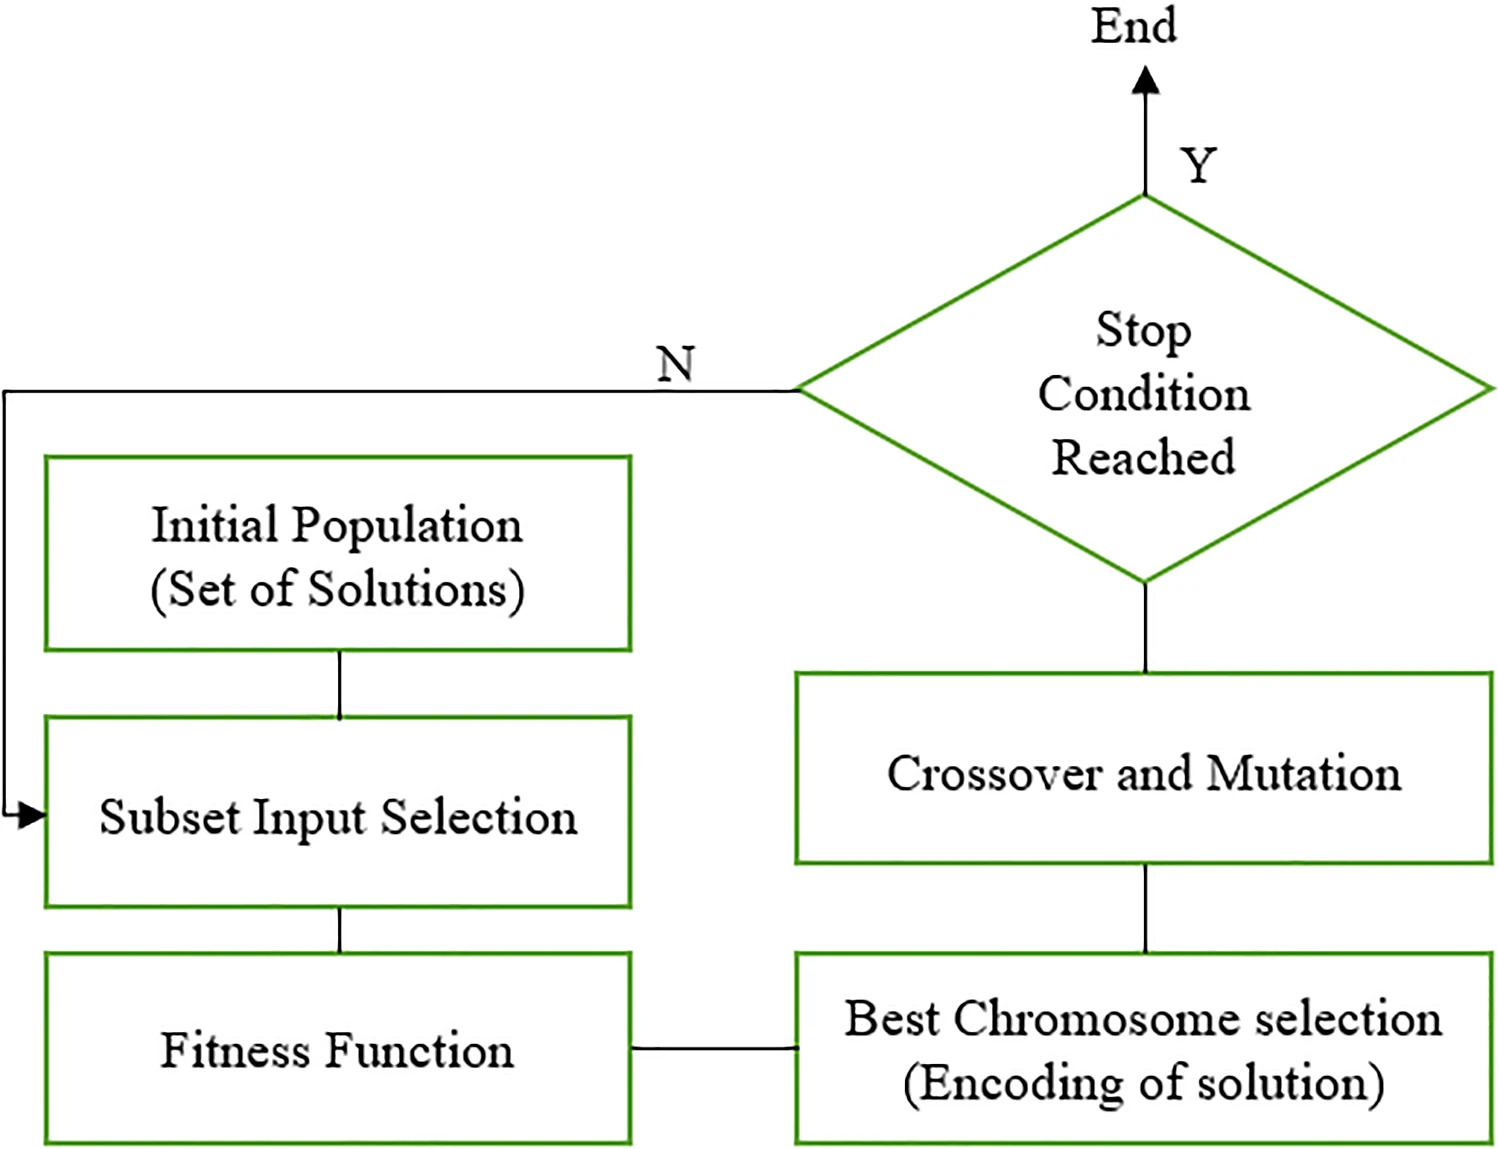

In [104]:
Image(filename="./image/genetic_algorithm.jpg")

### Initializing the Base Models

In [127]:
models = {
    'Logistic Regression': LogisticRegression(n_jobs=-1),
    'Gaussian Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(kernel='linear'),
    'MLP': MLPClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=10),
    'K-Nearest Neighbors': KNeighborsClassifier(n_jobs=-1),
}

### Initialization

Create an initial population of candidate solutions, typically represented as chromosomes. These chromosomes can be encoded as a numerical value or values that represent a candidate solution to the problem that the genetic algorithm is trying to solve (Carr, 2014). 

In [128]:
from functions.functions import population_init

### Evaluation

Calculate the fitness of each individual in the population using a predefined fitness function. The fitness function is the function that the algorithm aims to optimize, and it measures the 'fitness' or effectiveness of each potential solution (Carr, 2014).

Here, the accuracy is used as the fitness score.

In [129]:
from functions.functions import fitness_score

### Selection

Select individuals from the current population to serve as parents for the next generation. A selection operator picks some chromosomes for reproduction according to a probability distribution set by the user (Carr, 2014). This selection is typically fitness-based, meaning that individuals with higher fitness levels have a greater chance of being selected.

In our case the population were ranked based on the fitness score and individuals ranking within the best 50% fitness were selected to make the offspring.

In [130]:
from functions.functions import selection

### Crossover

Apply random mutations to the offspring chromosomes. The crossover operator mimics the biological process of crossing over and recombination of chromosomes during cell meiosis. It swaps a subsequence between two selected chromosomes to generate two offspring (Carr, 2014). 

A single-point crossover with a proportion of 0.6 was applied to develop the population.

In [131]:
from functions.functions import crossover

### Mutation

Apply random mutations to the offspring chromosomes. The mutation operator randomly alters individual bits in the new chromosomes, changing a 0 to a 1 or vice versa. Mutations typically occur with a very low probability, such as 0.001 (Carr, 2014).

Similarly, a single point mutation with a proportion of 0.033 was applied.

In [132]:
from functions.functions import mutation

### Replacement and Termination

Form the new population by replacing some or all of the old population with the new offspring. This can be done through various strategies, such as elitism which is the preservation of the best individuals.  The algorithm can stop when a predefined number of generations is reached, when there is no significant improvement in fitness over several generations, or when a satisfactory solution is found. Once the termination criteria are met, the algorithm outputs the best solution(s) found during the search process.

In [133]:
def generations(X, y, model_name, model, size, n_feat, selection_prop=0.5, crossover_prop=0.5, mutation_rate=0.3,
                n_elites=2, n_gen=5, stall_gen=2):
    # Initialize lists to keep track of the best chromosome and score in each generation
    best_chromo = []
    best_score = []

    # Initialize the count for consecutive generations with no change in the best chromosome
    consecutive_same_chromo = 0
    last_best_chromo = None

    # Initialize the first population
    population_nextgen = population_init(size, n_feat)

    print('\nClassifier Running:', model_name)

    # Run the genetic algorithm for a fixed number of generations
    for i in range(n_gen):
        # Evaluate the fitness of each chromosome in the population
        scores, pop_after_fit = fitness_score(
            population=population_nextgen,
            model=model,
            X=X,
            y=y,
        )

        print('Best score in generation', i + 1, ':', scores[:1], pop_after_fit[:1])

        # Check if the best chromosome has not changed from the previous generation
        if last_best_chromo is not None and np.array_equal(last_best_chromo, pop_after_fit[0]):
            consecutive_same_chromo += 1  # Increment the counter if no change
        else:
            consecutive_same_chromo = 0  # Reset the counter if there is a change

        last_best_chromo = pop_after_fit[0]  # Update the last best chromosome

        # Stop early if the best chromosome has not changed for a specified number of generations
        if consecutive_same_chromo >= stall_gen:
            print(
                f'Stopping early at generation {i + 1} because the best chromosome has not changed for {stall_gen} generations.')
            break

        # Select the top-performing chromosomes from the current population
        pop_after_sel = selection(pop_after_fit, selection_prop=selection_prop)

        # Perform crossover to create new chromosomes from the selected ones
        pop_after_cross = crossover(pop_after_sel, size, crossover_prop=crossover_prop)

        # Introduce mutations into the new population
        population_nextgen = mutation(pop_after_cross, n_feat, mutation_rate=mutation_rate)

        # Carry over the elite chromosomes from the current population to the next generation
        population_nextgen.extend(pop_after_fit[:n_elites])

        # Track the best chromosome and its score from the current generation
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])

    # Return the list of best chromosomes and their corresponding scores
    return best_chromo, best_score

### Implementation

In [134]:
heart_df = pd.read_csv("data/heart.dat", header=None, sep=" ")

column_names = [
    "age", "sex", "cp_type", "rest_bp", "cholesterol", "fast_bs", "rest_ecg",
    "max_hr", "ex_angina", "old_peak", "slope", "num_vessels", "thal", "hd_presence"
]

heart_df.columns = column_names
heart_df.head()

,age,sex,cp_type,rest_bp,cholesterol,fast_bs,rest_ecg,max_hr,ex_angina,old_peak,slope,num_vessels,thal,hd_presence
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1


## Using features based on the article

Here, we are dropping cholesterol, rest_bp, fast_bs, age, and sex as mentioned in the paper.

In [135]:
y = heart_df["hd_presence"]
X = heart_df.drop(["hd_presence", "age", "slope", "old_peak", "num_vessels"], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("Heart Disease dataset:", X.shape[0], "Records &", X.shape[1], "Features")

Heart Disease dataset: 270 Records & 9 Features


In [136]:
X_scaled.head()

,sex,cp_type,rest_bp,cholesterol,fast_bs,rest_ecg,max_hr,ex_angina,thal
0,0.689500,0.870928,-0.075410,1.402212,-0.417029,0.981664,-1.759208,-0.701222,-0.875706
1,-1.450327,-0.183559,-0.916759,6.093004,-0.417029,0.981664,0.446409,-0.701222,1.189277
2,0.689500,-1.238045,-0.411950,0.219823,-0.417029,-1.026285,-0.375291,-0.701222,1.189277
3,0.689500,0.870928,-0.187590,0.258589,-0.417029,-1.026285,-1.932198,1.426081,1.189277
4,-1.450327,-1.238045,-0.636310,0.374890,-0.417029,0.981664,-1.240239,1.426081,-0.875706


Here, we will be implementing the genetic Algorithm according to the parameter values used in the article.

*__GA Parameter Table__*

|     Parameter Name      |     Value      |
|:-----------------------:|:--------------:|
|     Population Size     |       50       | 
|  Number of Generations  |      100       |
| Proportion of Crossover |      0.6       |
| Proportion of Mutation  |     0.033      |
|    Type of Mutation     |    Uniform     |
| Stall Generation Limit  |       10       |
|       Elite Count       |       2        |
|    Fitness Function     | Linear Ranking |

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

selected_features = {}

for name, model in models.items():
    chromo_df_bc, score_bc = generations(
        X=X_train,
        y=y_train,
        model_name=name,
        model=model,
        size=50,
        n_feat=X.shape[1],
        selection_prop=0.5,
        crossover_prop=0.6,
        mutation_rate=0.033,
        n_elites=2,
        n_gen=100,
        stall_gen=10,
    )
    selected_features[name] = chromo_df_bc[-1]


Classifier Running: Logistic Regression
Best score in generation 1 : [0.8360655737704918] [array([ True,  True, False,  True,  True,  True,  True, False,  True])]
Best score in generation 2 : [0.8524590163934426] [array([False,  True,  True,  True, False,  True,  True, False,  True])]
Best score in generation 3 : [0.8524590163934427] [array([False,  True,  True,  True, False, False,  True, False,  True])]
Best score in generation 4 : [0.8524590163934427] [array([False,  True,  True,  True, False, False,  True, False,  True])]
Best score in generation 5 : [0.8524590163934427] [array([False,  True,  True,  True, False, False,  True, False,  True])]
Best score in generation 6 : [0.8524590163934427] [array([False,  True,  True,  True, False, False,  True, False,  True])]
Best score in generation 7 : [0.8524590163934427] [array([False,  True,  True,  True, False, False,  True, False,  True])]
Best score in generation 8 : [0.8524590163934427] [array([False,  True,  True,  True, False, False

KeyboardInterrupt: 

In [ ]:
selected_features

In [ ]:
def get_selected_col_names(df, selected_tf):
    correct_columns = {}

    for model, bool_list in selected_tf.items():
        if len(bool_list) != len(df.columns):
            raise ValueError(
                f"Length of boolean list for model {model} does not match number of columns in the DataFrame.")

        correct_columns[model] = [col for col, correct in zip(df.columns, bool_list) if correct]

    return correct_columns


correct_columns_base = get_selected_col_names(X, selected_features)

for key, val in correct_columns_base.items():
    print(f"{key}: {val}")

## Modelling with Base Learners and Ensemble Learning

Ensemble learning is a machine learning technique that combines the predictions of multiple base models to improve performance and generalization. The key idea is to leverage the strengths and mitigate the weaknesses of individual models by combining them. Ensemble methods can be broadly categorized into three main types, however, for this research, stacked generalization has been utlized (Mienye & Sun, 2022).

Stacking involves training multiple models (level-0 models) as base learners and then using their predictions as input features for a higher-level model (level-1 model) as meta-learner, which learns how to best combine these predictions (Mienye & Sun, 2022). In this study, the models that resulted from the genetic algorithm feature selection were used as base learners and AdaBoostClassifier is used as the meta-learner. This method can effectively integrate diverse model types and leverage their combined strengths.

### Ensemble Learning with Stacked Generalization

We will now be using the classification results from the base models to train our metamodel (AdaBoost).

In [ ]:
trained_base_models = []

for name, model in models.items():
    # Get the features selected for the current model
    new_selected_features = X_train.columns[selected_features[name]]

    # Train the model using the selected features and the training labels
    trained_base_models.append((name, model.fit(X_train[new_selected_features], y_train)))

# Create meta-features for the training set by stacking predictions from each trained base model
meta_X_train = np.column_stack(
    [model.predict(X_train[X_train.columns[selected_features[name]]]) for name, model in trained_base_models])

# Create meta-features for the test set by stacking predictions from each trained base model
meta_X_test = np.column_stack(
    [model.predict(X_test[X_test.columns[selected_features[name]]]) for name, model in trained_base_models])

meta_chromosome, meta_score = generations(
    X=pd.DataFrame(meta_X_train),
    y=y_train,
    model_name='Meta-Classifier',
    model=AdaBoostClassifier(),
    size=50,
    n_feat=meta_X_train.shape[1],
    selection_prop=0.5,
    crossover_prop=0.6,
    mutation_rate=0.033,
    n_elites=2,
    n_gen=100,
    stall_gen=10,
)

## Evaluation and Results

In [ ]:
from functions.functions import evaluate_model

We will be using three metrics accuracy, sensitivity and specificity to measure the performance of our models.

Accuracy: Indicate the quantity of “correct predictions made” by the category, divided by the quantity of “total predictions made” by a similar category. In other words, accuracy is the fraction of predictions our model got right.

Sensitivity (Recall): It refers to a models ability to designate a positive case as positive i.e. the true positive rate. A highly sensitive model means that there are few false negative results, and thus fewer cases of positives being missed. 

Specificity: The specificity of a model is its ability to designate a negative case as negative.

TODO: maybe? explain why we use these metrics, why we did k fold, why we used CV

### Base Models

In [ ]:
k_folds = [0, 2, 5, 10]
evaluation_results = {}

for name, model in models.items():
    # Retrieve the selected features for the current model
    selected_feat = selected_features[name]

    # Select the relevant columns from the test data based on the selected features
    X_test_selected = X_test.iloc[:, selected_feat]

    evaluation_results[name] = evaluate_model(model, X_test_selected, y_test, k_folds)

evaluation_results

### Ensemble Learning (AdaBoost)

In [ ]:
meta_model = AdaBoostClassifier()

# Select the features from the final chromosome obtained from the genetic algorithm
selected_meta_features = meta_chromosome[-1]

# Use the selected meta-features to filter the columns from the meta-test features
X_test_stacked = meta_X_test[:, selected_meta_features]

# Evaluate the metamodel using the selected meta-features from the test data and the defined k-folds
stacked_results = evaluate_model(meta_model, X_test_stacked, y_test, k_folds)
stacked_results

In [ ]:
evaluation_results['Stacked Model'] = stacked_results


def get_result_df(eval_results, k_folds):
    table_data = {
        'Model': [],
        'ACC Holdout': [], 'Sen Holdout': [], 'Spec Holdout': [],
        'ACC K-fold 2': [], 'Sen K-fold 2': [], 'Spec K-fold 2': [],
        'ACC K-fold 5': [], 'Sen K-fold 5': [], 'Spec K-fold 5': [],
        'ACC K-fold 10': [], 'Sen K-fold 10': [], 'Spec K-fold 10': []
    }

    for name, results in eval_results.items():
        table_data['Model'].append(name)

        for i, k in enumerate(k_folds):
            table_data[f'ACC K-fold {k}' if k != 0 else 'ACC Holdout'].append(results['accuracy'][i])
            table_data[f'Sen K-fold {k}' if k != 0 else 'Sen Holdout'].append(results['sensitivity'][i])
            table_data[f'Spec K-fold {k}' if k != 0 else 'Spec Holdout'].append(results['specificity'][i])

    return pd.DataFrame(table_data)


eval_df = get_result_df(evaluation_results, k_folds)
eval_df

In [ ]:
def eval_metrics_by_plot(results_df):
    cmap = plt.get_cmap('cool')

    fig, ax = plt.subplots(figsize=(12, 6))

    bar_width = 0.2
    index = np.arange(len(results_df['Model']))

    colors = [cmap(i / 3) for i in range(3)]

    for i, (metric, color) in enumerate(zip(['ACC Holdout', 'Sen Holdout', 'Spec Holdout'], colors)):
        ax.bar(index + i * bar_width, results_df[metric], bar_width, label=metric, color=color)

    ax.set_xlabel('Algorithms')
    ax.set_ylabel('Percent')
    ax.set_title('Evaluation Metrics by Algorithm')
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')
    ax.legend(loc="lower right")

    plt.tight_layout()
    plt.show()


eval_metrics_by_plot(eval_df)

## Using features based on our results

Here, we are dropping rest_bp, fast_bs, and rest_ecg according to our results.

In [ ]:
y = heart_df["hd_presence"]
X = heart_df.drop(["hd_presence", "rest_bp", "fast_bs", "rest_ecg"], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("Heart Disease dataset:", X.shape[0], "Records &", X.shape[1], "Features")

In [ ]:
X_scaled.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

selected_features = {}

for name, model in models.items():
    chromo_df_bc, score_bc = generations(
        X=X_train,
        y=y_train,
        model_name=name,
        model=model,
        size=50,
        n_feat=X.shape[1],
        selection_prop=0.5,
        crossover_prop=0.6,
        mutation_rate=0.033,
        n_elites=2,
        n_gen=100,
        stall_gen=10,
    )
    selected_features[name] = chromo_df_bc[-1]

In [ ]:
selected_features

In [ ]:
def get_selected_col_names(df, selected_tf):
    correct_columns = {}

    for model, bool_list in selected_tf.items():
        if len(bool_list) != len(df.columns):
            raise ValueError(
                f"Length of boolean list for model {model} does not match number of columns in the DataFrame.")

        correct_columns[model] = [col for col, correct in zip(df.columns, bool_list) if correct]

    return correct_columns


correct_columns_base = get_selected_col_names(X, selected_features)

for key, val in correct_columns_base.items():
    print(f"{key}: {val}")

### Ensemble Learning with Stacked Generalization

We will now be using the classification results from the base models to train our metamodel (AdaBoost).

In [ ]:
trained_base_models = []

for name, model in models.items():
    # Get the features selected for the current model
    new_selected_features = X_train.columns[selected_features[name]]

    # Train the model using the selected features and the training labels
    trained_base_models.append((name, model.fit(X_train[new_selected_features], y_train)))

# Create meta-features for the training set by stacking predictions from each trained base model
meta_X_train = np.column_stack(
    [model.predict(X_train[X_train.columns[selected_features[name]]]) for name, model in trained_base_models])

# Create meta-features for the test set by stacking predictions from each trained base model
meta_X_test = np.column_stack(
    [model.predict(X_test[X_test.columns[selected_features[name]]]) for name, model in trained_base_models])

meta_chromosome, meta_score = generations(
    X=pd.DataFrame(meta_X_train),
    y=y_train,
    model_name='Meta-Classifier',
    model=AdaBoostClassifier(),
    size=50,
    n_feat=meta_X_train.shape[1],
    selection_prop=0.5,
    crossover_prop=0.6,
    mutation_rate=0.033,
    n_elites=2,
    n_gen=100,
    stall_gen=10,
)

In [ ]:
k_folds = [0, 2, 5, 10]
evaluation_results = {}

for name, model in models.items():
    # Retrieve the selected features for the current model
    selected_feat = selected_features[name]

    # Select the relevant columns from the test data based on the selected features
    X_test_selected = X_test.iloc[:, selected_feat]

    evaluation_results[name] = evaluate_model(model, X_test_selected, y_test, k_folds)

evaluation_results

In [ ]:
meta_model = AdaBoostClassifier()

selected_meta_features = meta_chromosome[-1]

X_test_stacked = meta_X_test[:, selected_meta_features]

stacked_results = evaluate_model(meta_model, X_test_stacked, y_test, k_folds)
stacked_results

In [ ]:
evaluation_results['Stacked Model'] = stacked_results

eval_our_df = get_result_df(evaluation_results, k_folds)
eval_our_df

## Comparisons by Evaluation Metrics

In [ ]:
eval_metrics_by_plot(eval_df)  # our method using article features 

In [ ]:
eval_metrics_by_plot(eval_our_df)  # our method using our features

In [ ]:
Image(filename="./image/evaluation_metrics_by_algorithm.png")  # article

## Comparison on Accuracy by K-Folds 

In [ ]:
# TODO: accuracy graph # our method using article features 

In [ ]:
# our method using our features

In [ ]:
Image(filename="./image/accuracy_by_k_fold.png")  # article

## Conclusions

TODO: Write the comparison things here...

#### Areas for Improvement

One key area for improvement is hyperparameter tuning. Due to some technical limitations, we were unable to thoroughly explore and optimize hyperparameters for our models. Hyperparameter tuning is essential for squeezing out the best performance from our algorithms, and without it, we may not be reaching the full potential of our models. To address this, we plan to implement a systematic approach to hyperparameter optimization. This could involve using techniques like Grid Search and Random Search.

#### Next Steps

Looking ahead, one of our primary goals is to train our models on significantly larger datasets. Expanding the volume of data will help improve the model’s generalization capabilities and make it more robust. By incorporating additional data we can enhance the model's performance and reliability.

Another important step is to work with datasets that have a larger number of features as the one we used for this project has a small number of features. By integrating datasets that include a broader array of features, we aim to capture more nuanced information, which can lead to more accurate and insightful predictions. We plan to employ feature engineering techniques to create new features or select the most important ones, and consider dimensionality reduction methods such as Principal Component Analysis (PCA) to manage and streamline the data.

Additionally, we will focus on optimizing our code to speed up the training process which has been the primary bottleneck for this project. This includes exploring parallel processing options, utilizing GPU acceleration where possible, and improving data handling efficiency. By making these adjustments, we can reduce training time and accelerate our experimentation.

Lastly, a key enhancement for our project will involve expanding the number of models stacked together. Currently, our approach stacks 7 models, but increasing this to maybe 10 models will allow us to leverage a broader range of model predictions, which could improve overall performance. Additionally, we aim to implement a multi-level stacking strategy. Instead of the current 2-level approach, we could explore a 3 or 4-level stacking approach. This will enable us to build more complex metamodels that can integrate a richer set of predictions from different base models, potentially leading to more accurate and robust outcomes.

## References

Wang, Z., Zhang, Y., Chen, Z., Yang, H., Sun, Y., Kang, J., Yang, Y., & Liang, X. (2016). Application of ReliefF algorithm to selecting feature sets for classification of high resolution remote sensing image. https://doi.org/10.1109/igarss.2016.7729190

Yu, L., & Liu, H. (n.d.). Feature Selection for High-Dimensional Data: A Fast Correlation-Based Filter Solution. https://cdn.aaai.org/ICML/2003/ICML03-111.pdf

Carr, J. (2014). An Introduction to Genetic Algorithms. https://www.whitman.edu/Documents/Academics/Mathematics/2014/carrjk.pd

Mienye, I. D., & Sun, Y. (2022). A Survey of Ensemble Learning: Concepts, Algorithms, Applications, and Prospects. IEEE Access, 10, 99129–99149. https://doi.org/10.1109/ACCESS.2022.3207287f
‌